In [48]:
# 📌 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
import joblib
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier


In [49]:
# 📌 2. Load dataset
df = pd.read_csv(r"E:\lightgbm\data\Train.csv")   # change path if needed
df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,labels
0,-0.276515,-0.424429,1.344997,-0.012283,0.076230,1.076648,0.182198,3,0,1,0,0,0,0,10,2,1
1,0.853573,0.150991,0.503892,-0.979179,-0.569351,-0.411453,-0.251940,4,1,2,0,1,0,0,0,3,0
2,0.947747,-0.173832,1.825628,-0.703478,0.076230,-0.411453,-0.251940,6,1,2,0,0,0,0,5,3,0
3,0.853573,-0.381404,0.984523,-0.039464,-0.569351,-0.411453,-0.251940,4,0,2,0,1,0,0,5,3,0
4,1.324443,1.590527,-1.178318,-0.097711,-0.246560,-0.411453,-0.251940,0,1,1,0,0,0,0,8,3,0


In [50]:
# 📌 3. Select target column
target_col = "labels"   # change if your target column has a different name
X = df.drop(columns=[target_col])
y = df[target_col]


In [51]:
# 📌 4. Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [52]:
# 📌 4. Handle Imbalance with SMOTETomek
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)
print("Class distribution after SMOTETomek:", pd.Series(y_train_res).value_counts())

Class distribution after SMOTETomek: labels
0    23911
1    23911
Name: count, dtype: int64


In [53]:
# 📌 5. Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [54]:
# 📌 6. Train LightGBM
model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    class_weight=None  # SMOTETomek already balances
)
model.fit(X_train_scaled, y_train_res)


[LightGBM] [Info] Number of positive: 23911, number of negative: 23911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 47822, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [55]:
# 📌 7. Threshold Tuning
y_proba = model.predict_proba(X_test_scaled)[:, 1]
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_thr = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_thr)

c:\Users\CHARUKONDA NAGARAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best Threshold: 0.29000000000000004


In [56]:
# 📌 8. Final evaluation
y_pred = (y_proba >= best_thr).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8897080507225007
Precision: 0.51931330472103
Recall: 0.7629255989911727
F1 Score: 0.6179775280898876
ROC-AUC: 0.9291085780003988

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      5989
           1       0.52      0.76      0.62       793

    accuracy                           0.89      6782
   macro avg       0.74      0.83      0.78      6782
weighted avg       0.91      0.89      0.90      6782



In [62]:
import numpy as np
from sklearn.metrics import f1_score

# Check tuned threshold
print("Best Threshold:", best_thr)

# Predict on test set
y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= best_thr).astype(int)

# Distribution of predictions
print("Prediction counts:", np.bincount(y_pred))
print("Mean churn probability:", np.mean(y_proba))

# F1 at best threshold
print("F1 score at best threshold:", f1_score(y_test, y_pred))


Best Threshold: 0.29000000000000004
Prediction counts: [5617 1165]
Mean churn probability: 0.1313589149287365


c:\Users\CHARUKONDA NAGARAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 score at best threshold: 0.6179775280898876


In [58]:
# 📌 8. Final Evaluation
y_pred = (y_proba >= best_thr).astype(int)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.98      0.36      0.52      5989
           1       0.16      0.95      0.28       793

    accuracy                           0.43      6782
   macro avg       0.57      0.65      0.40      6782
weighted avg       0.88      0.43      0.49      6782

ROC AUC: 0.826185648889294


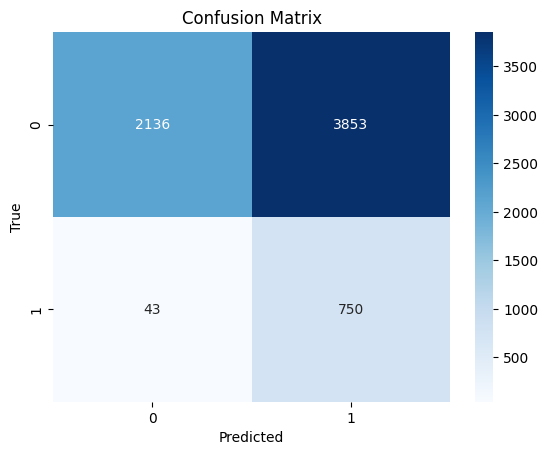

In [59]:
# 📌 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.savefig(r"E:\lightgbm\confusion_matrix.png")   # save confusion matrix image
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


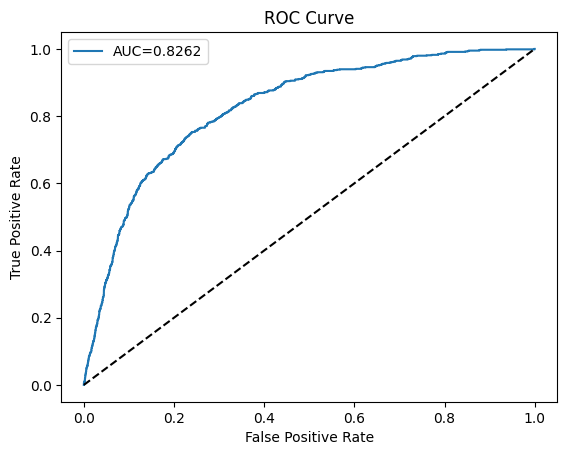

In [60]:
# 📌 10. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.savefig(r"E:\lightgbm\roc_curve.png")   # save ROC curve image
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

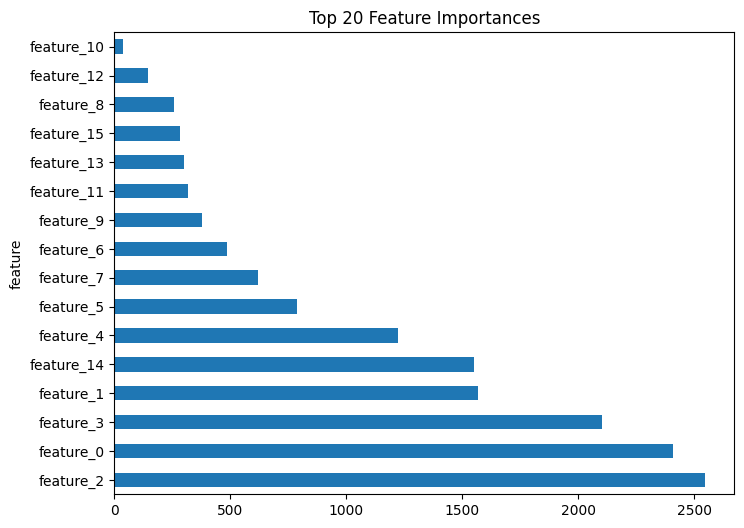

In [63]:
# 📌 11. Feature Importance
importances = model.feature_importances_
feat_imp = pd.DataFrame({"feature": X.columns, "importance": importances})
feat_imp.sort_values("importance", ascending=False).head(20).plot(
    x="feature", y="importance", kind="barh", figsize=(8,6), legend=False
)
plt.savefig(r"E:\lightgbm\feature_importance.png")   # save feature importance image
plt.title("Top 20 Feature Importances")
plt.show()

In [65]:
import joblib

# ✅ Save trained LightGBM model
joblib.dump(model, "lgbm_model.pkl")

# ✅ Save fitted scaler
joblib.dump(scaler, "scaler.pkl")

# ✅ Save best threshold
joblib.dump(best_thr, "best_threshold.pkl")

print("✅ Model, Scaler, and Threshold saved successfully!")


✅ Model, Scaler, and Threshold saved successfully!
